In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import requests
from thefuzz import process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import xgboost as xgb
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# ==========================
# TMDb API Setup
# ==========================
TMDB_API_KEY = '6f47f7af'

def get_tmdb_person_rating(name):
    try:
        search_url = f'https://api.themoviedb.org/3/search/person?api_key={TMDB_API_KEY}&query={name}'
        response = requests.get(search_url).json()

        if response and 'results' in response and response['results']:
            person_id = response['results'][0]['id']
            credits_url = f'https://api.themoviedb.org/3/person/{person_id}/movie_credits?api_key={TMDB_API_KEY}'
            credits_response = requests.get(credits_url).json()

            ratings = []
            for movie in credits_response.get('crew', []) + credits_response.get('cast', []):
                if 'vote_average' in movie and movie['vote_average'] > 0:
                    ratings.append(movie['vote_average'])

            if ratings:
                return sum(ratings) / len(ratings)

        return None

    except Exception as e:
        print(f"Error fetching data from TMDb: {e}")
        return None

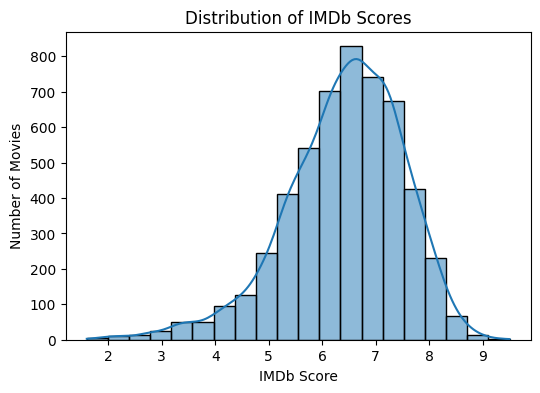

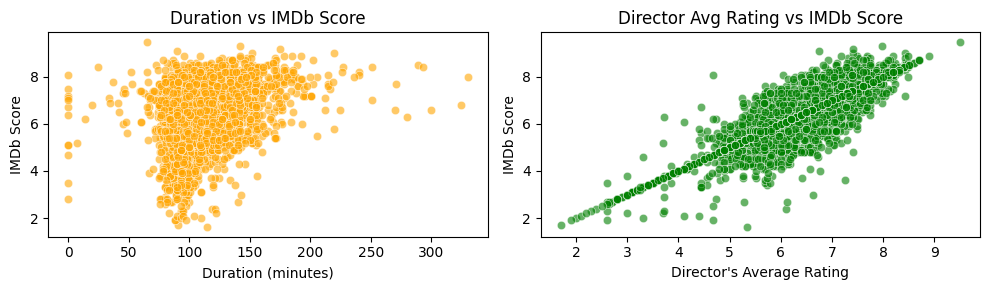

In [3]:
# ==========================
# Step 1: Load and Clean Data
# ==========================
df = pd.read_csv('Movie_Dataset_p.csv', encoding='ISO-8859-1')

df.dropna(subset=['director_name', 'actor1_name', 'actor2_name', 'imdb_score'], inplace=True)

df['director_name'] = df['director_name'].str.strip().str.lower()
df['actor1_name'] = df['actor1_name'].str.strip().str.lower()
df['actor2_name'] = df['actor2_name'].str.strip().str.lower()
df['genres'] = df['genres'].str.strip()

cols_to_clean = ['movie_title', 'director_name', 'actor1_name', 'actor2_name', 'genres']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('\xa0', '', regex=True).str.strip()

df['duration'].fillna(df['duration'].mean(), inplace=True)
df['language'].fillna(df['language'].mode()[0], inplace=True)

# ==========================
# Step 2: Compute Average Ratings
# ==========================
director_avg = df.groupby('director_name')['imdb_score'].mean().to_dict()
actor1_avg = df.groupby('actor1_name')['imdb_score'].mean().to_dict()
actor2_avg = df.groupby('actor2_name')['imdb_score'].mean().to_dict()

df['director_avg_rating'] = df['director_name'].map(director_avg)
df['actor1_avg_rating'] = df['actor1_name'].map(actor1_avg)
df['actor2_avg_rating'] = df['actor2_name'].map(actor2_avg)

# ==========================
# Step 3: Visualizations
# ==========================
plt.figure(figsize=(6, 4))
sns.histplot(df['imdb_score'], bins=20, kde=True)
plt.title("Distribution of IMDb Scores")
plt.xlabel("IMDb Score")
plt.ylabel("Number of Movies")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(x='duration', y='imdb_score', data=df, color='orange', alpha=0.6, ax=axes[0])
axes[0].set_title("Duration vs IMDb Score")
axes[0].set_xlabel("Duration (minutes)")
axes[0].set_ylabel("IMDb Score")

sns.scatterplot(x='director_avg_rating', y='imdb_score', data=df, color='green', alpha=0.6, ax=axes[1])
axes[1].set_title("Director Avg Rating vs IMDb Score")
axes[1].set_xlabel("Director's Average Rating")
axes[1].set_ylabel("IMDb Score")

plt.tight_layout()
plt.show()

In [4]:
# ==========================
# Step 4: One-Hot Encode Genres
# ==========================
df['genres_list'] = df['genres'].str.split(',').apply(lambda x: [i.strip() for i in x])
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
df = pd.concat([df, genre_df], axis=1)

for col in mlb.classes_:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

genre_cols = mlb.classes_


Model Evaluation Results:
                 Model     MSE  R² Score
1        Random Forest  0.1723    0.8644
2              XGBoost  0.1805    0.8579
0    Linear Regression  0.1808    0.8577
3  K-Nearest Neighbors  0.2817    0.7782
4        MLP Regressor  0.4302    0.6613


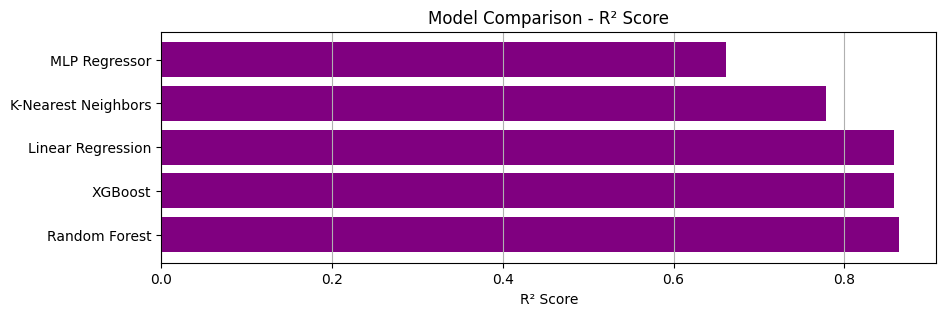

RandomForestRegressor(random_state=42)

In [5]:
# ==========================
# Step 5: Prepare Data for Modeling
# ==========================
feature_columns = ['duration', 'director_avg_rating', 'actor1_avg_rating', 'actor2_avg_rating'] + list(genre_cols)
X = df[feature_columns]
y = df['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# Step 6: Train and Evaluate Models
# ==========================
results = []

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'MSE': round(mse, 4), 'R² Score': round(r2, 4)})

evaluate_model("Linear Regression", LinearRegression())
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42))
evaluate_model("XGBoost", xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
evaluate_model("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=5))
evaluate_model("MLP Regressor", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42))

results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("Model Evaluation Results:")
print(results_df)

plt.figure(figsize=(10, 3))
plt.barh(results_df['Model'], results_df['R² Score'], color='purple')
plt.xlabel("R² Score")
plt.title("Model Comparison - R² Score")
plt.grid(axis='x')
plt.show()

# ==========================
# Step 7: Final Model Training (Random Forest)
# ==========================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [6]:
# ==========================
# Step 8: Save Model and Data
# ==========================
with open("best_movie_rating_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)
with open("genre_classes.pkl", "wb") as f:
    pickle.dump(mlb.classes_, f)
with open("director_avg.pkl", "wb") as f:
    pickle.dump(director_avg, f)
with open("actor1_avg.pkl", "wb") as f:
    pickle.dump(actor1_avg, f)
with open("actor2_avg.pkl", "wb") as f:
    pickle.dump(actor2_avg, f)

print("✅ Model and support data saved successfully.")


✅ Model and support data saved successfully.


In [7]:
# ==========================
# Step 9: Helper - Fuzzy Matching
# ==========================
def get_closest_match(input_name, choices):
    match, score = process.extractOne(input_name, choices)
    if score >= 80:
        print(f"🧩 Fuzzy matched '{input_name}' to '{match}' with score {score}")
        return match
    return input_name.lower()

# ==========================
# Step 10: Fallback with TMDb Integration
# ==========================
def get_average_rating(entity_name, entity_avg_dict, genre=None, entity_type="director"):
    entity_name = entity_name.lower()

    if entity_name in entity_avg_dict:
        return entity_avg_dict[entity_name]

    tmdb_rating = get_tmdb_person_rating(entity_name)
    if tmdb_rating:
        print(f"⭐ TMDb API rating for {entity_name}: {tmdb_rating}")
        return tmdb_rating

    if genre:
        genre_df = df[df['genres'].str.contains(genre, case=False)]
        if entity_type == "director" and not genre_df['director_avg_rating'].empty:
            return genre_df['director_avg_rating'].mean()
        if entity_type == "actor":
            actor_ratings = pd.concat([genre_df['actor1_avg_rating'], genre_df['actor2_avg_rating']])
            if not actor_ratings.empty:
                return actor_ratings.mean()

    print(f"⚠️ Fallback to global average for {entity_name}")
    return np.mean(list(entity_avg_dict.values()))


In [8]:
# ==========================
# Step 11: Prediction Function
# ==========================
def predict_movie_rating(director, actor1, actor2, genres, duration, model):
    director_choices = list(director_avg.keys())
    actor_choices = list(actor1_avg.keys()) + list(actor2_avg.keys())
    genre_choices = list(mlb.classes_)

    # Fuzzy match inputs
    director = get_closest_match(director, director_choices)
    actor1 = get_closest_match(actor1, actor_choices)
    actor2 = get_closest_match(actor2, actor_choices)

    cleaned_genres = []
    for g in genres:
        g = g.strip().lower()
        match, score = process.extractOne(g, genre_choices)
        if score >= 80:
            print(f"🧩 Fuzzy matched genre '{g}' to '{match}' with score {score}")
            cleaned_genres.append(match)
        else:
            print(f"⚠️ Genre '{g}' not recognized, skipping.")
    print(f"✅ Recognized genres for input: {', '.join(cleaned_genres)}")

    selected_genre = cleaned_genres[0] if cleaned_genres else None
    dir_score = get_average_rating(director, director_avg, selected_genre, "director")
    act1_score = get_average_rating(actor1, actor1_avg, selected_genre, "actor")
    act2_score = get_average_rating(actor2, actor2_avg, selected_genre, "actor")

    genre_input = {genre: 0 for genre in mlb.classes_}
    for g in cleaned_genres:
        genre_input[g] = 1

    input_dict = {
        'duration': duration,
        'director_avg_rating': dir_score,
        'actor1_avg_rating': act1_score,
        'actor2_avg_rating': act2_score,
        **genre_input
    }
    input_df = pd.DataFrame([input_dict])
    predicted_rating = model.predict(input_df)[0]

    def get_recommendation(score):
        if score >= 8.0:
            return "🌟 Must Watch"
        elif score >= 6.5:
            return "👍 Give It One Try"
        elif score >= 5.0:
            return "🤔 Watch if You Have Time"
        else:
            return "❌ Skip"

    recommendation = get_recommendation(predicted_rating)
    return round(predicted_rating, 2), recommendation, genre_input

In [9]:
# ==========================
# Step 12: Similar Movies Finder
# ==========================
def get_similar_movies(input_genres, original_df, genre_cols, top_n=5):
    genre_matrix = original_df[genre_cols].astype(float)
    input_vector = pd.DataFrame([input_genres], columns=genre_cols).astype(float)
    sim_scores = cosine_similarity(genre_matrix, input_vector)[..., 0]
    original_df = original_df.copy()
    original_df['similarity'] = sim_scores
    return original_df.sort_values(by='similarity', ascending=False)[['movie_title', 'genres', 'imdb_score']].head(top_n)

In [10]:
# ==========================
# Step 13: User Input and Run
# ==========================
if __name__ == "__main__":
    director = input("Enter Director's Name: ")
    actor1 = input("Enter Actor 1's Name: ")
    actor2 = input("Enter Actor 2's Name: ")
    genres_input = input("Enter genres (comma-separated, e.g. Action,Thriller): ")
    genres = [g.strip() for g in genres_input.split(',')]
    duration = int(input("Enter movie duration in minutes: "))

    predicted_rating, suggestion, input_genre_vector = predict_movie_rating(director, actor1, actor2, genres, duration, rf_model)
    print("\n🎬 Predicted IMDb Rating:", predicted_rating)
    print("✅ Recommendation:", suggestion)

    recommendations = get_similar_movies(input_genre_vector, df.copy(), mlb.classes_)
    print("\n🎯 You might also like:")
    for _, row in recommendations.iterrows():
        print(f"🎬 {row['movie_title']} | Genres: {row['genres']} |  {row['imdb_score']} ⭐")


🧩 Fuzzy matched 'rajkumar hirani' to 'rajkumar hirani' with score 100
🧩 Fuzzy matched 'salman khan' to 'salman khan' with score 100
🧩 Fuzzy matched 'aamir khan' to 'aamir khan' with score 100
🧩 Fuzzy matched genre 'action' to 'Action' with score 100
🧩 Fuzzy matched genre 'romance' to 'Romance' with score 100
✅ Recognized genres for input: Action, Romance

🎬 Predicted IMDb Rating: 7.71
✅ Recommendation: 👍 Give It One Try

🎯 You might also like:
🎬 R... Rajkumar | Genres: Action, Comedy, Romance |  5.2 ⭐
🎬 This Means War | Genres: Action,Comedy,Romance |  6.3 ⭐
🎬 Top Gun | Genres: Action,Drama,Romance |  6.9 ⭐
🎬 The Musketeer | Genres: Action,Adventure,Romance |  4.7 ⭐
🎬 A Knight's Tale | Genres: Action,Adventure,Romance |  6.9 ⭐
